In [1]:
pip install yfinance

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import yfinance as yf


Applied to stock prices, clustering techniques groups together price levels thathave been frequently visited over a specific time frame. The central positions ofthese clusters, called centroids, then signify key price levels where significanttrading activity has occurred.

### Data Ingestion

Hardcoded for a single stock, it can be optimized.

In [75]:
symbol = "SPY"
start_date = "2013-01-01"
end_date = "2023-11-28"

stock_data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


#### Data normalization

In [76]:
# Time values in range 0 - 1
X_time = np.linspace(0, 1, len(stock_data)).reshape(-1, 1)

# Min max scaler for prices (Adj Close)
stock_close = stock_data['Adj Close'].values
min_close = np.min(stock_close)
max_close = np.max(stock_close)
normalized_close = (stock_close - min_close) / (max_close - min_close)

In [77]:
# Stacked Matrix - Time | prices
X_price = normalized_close.reshape(-1, 1)
X_cluster = np.column_stack((X_time, X_price))

### Clustering

In [78]:
from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

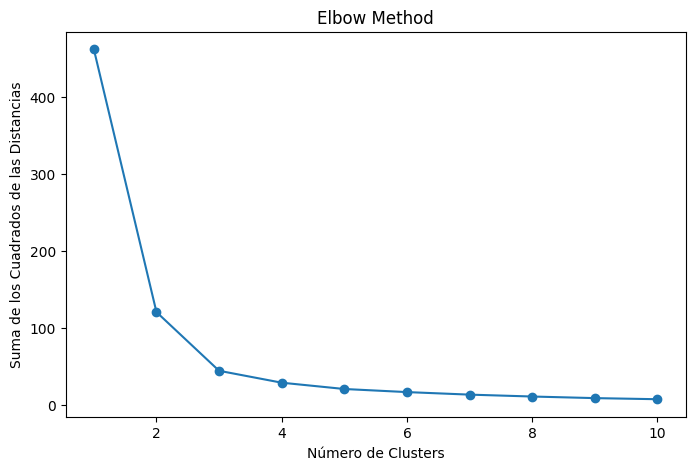

In [79]:
sse = []

# Probar con diferentes números de clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_cluster)
    sse.append(kmeans.inertia_)  # inertia_ almacena la suma de los cuadrados de las distancias

# Graficar la curva de codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de los Cuadrados de las Distancias')
plt.show()

In [87]:
num_clusters = 10

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X_cluster)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

In [88]:
cluster_centers = kmeans.cluster_centers_[:, 1] * (np.max(stock_data['Adj Close']) - np.min(stock_data['Adj Close'])) + np.min(stock_data['Adj Close'])


In [89]:
key_levels = np.sort(cluster_centers)
print(key_levels)

[137.922955   168.49670523 180.28852372 215.16688062 250.35884262
 283.25471573 347.04685367 389.4139092  427.30175815 436.31747821]


### Plot graph

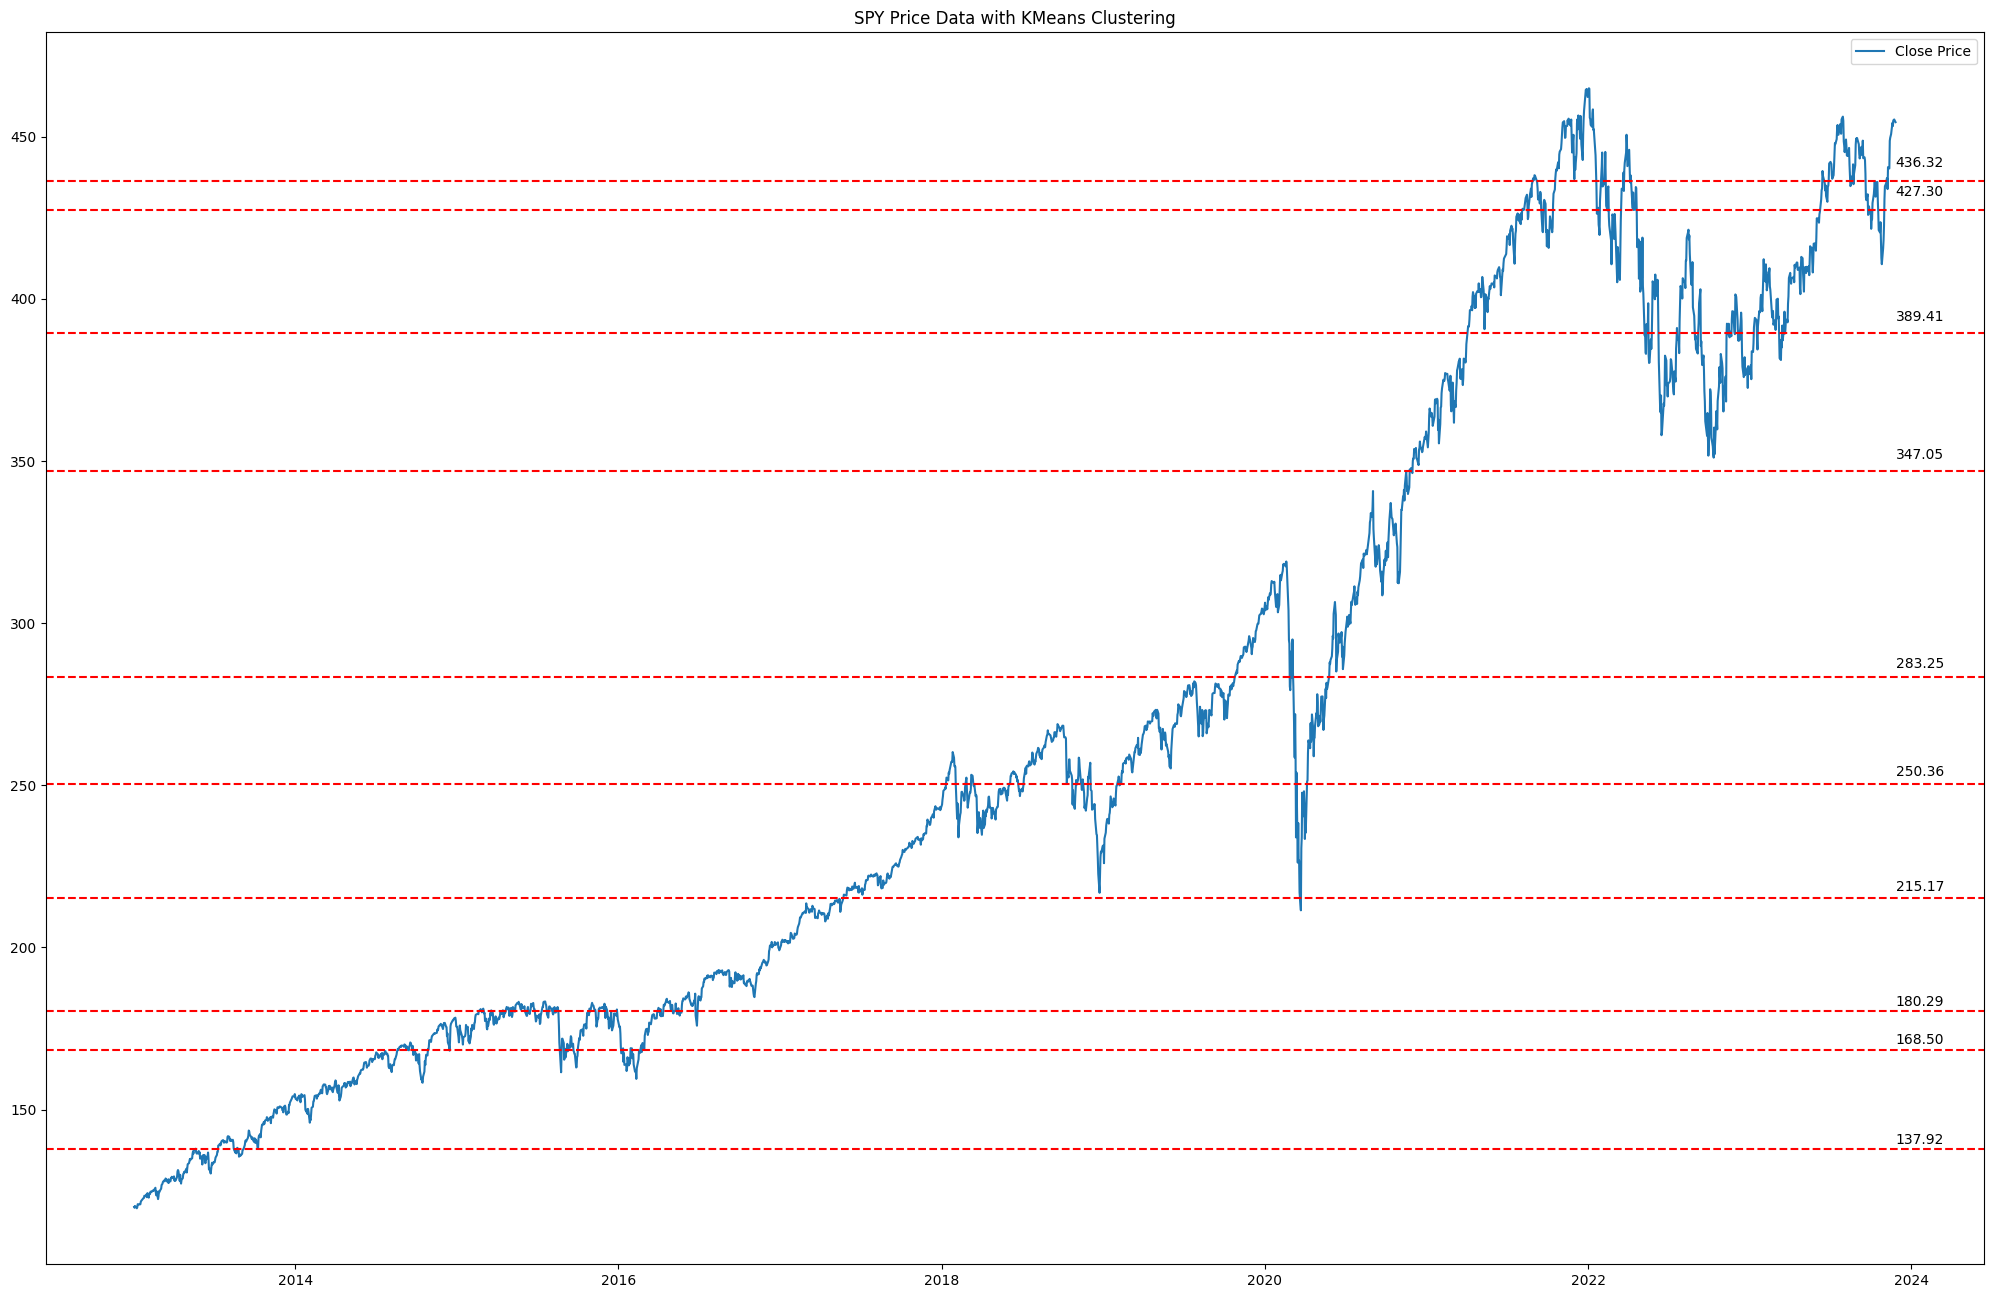

In [90]:
plt.figure(figsize=(25, 16))
plt.plot(stock_data['Adj Close'], label="Close Price")

for center in cluster_centers:
    plt.axhline(y=center, color='r', linestyle='--')
    plt.annotate(f"{center:.2f}", xy=(stock_data.index[-1], center * 1.01), xytext=(stock_data.index[-1], center * 1.01))

plt.title(f'{symbol} Price Data with KMeans Clustering')
plt.legend()
plt.show()


### Volume profile

Considering the volume of trades across various price levels holds significance. The volume profile offers a graphical depiction of trading activity (volume) at distinct price levels within a designated time frame. Unlike the volume histogram that charts volume over time, the volume profile maps volume against price. This enables the identification of price levels characterized by substantial trading activity. Such high-volume areas frequently function as notable support or resistance levels due to their representation of past instances where considerable buying or selling occurred.

In [91]:

price_bins = np.linspace(stock_data['Low'].min(), stock_data['High'].max(), 100)
volume_profile = []

In [92]:
for i in range(len(price_bins) - 1):
    bin_mask = (stock_data['Close'] > price_bins[i]) & (stock_data['Close'] <= price_bins[i + 1])
    volume_profile.append(stock_data['Volume'][bin_mask].sum())


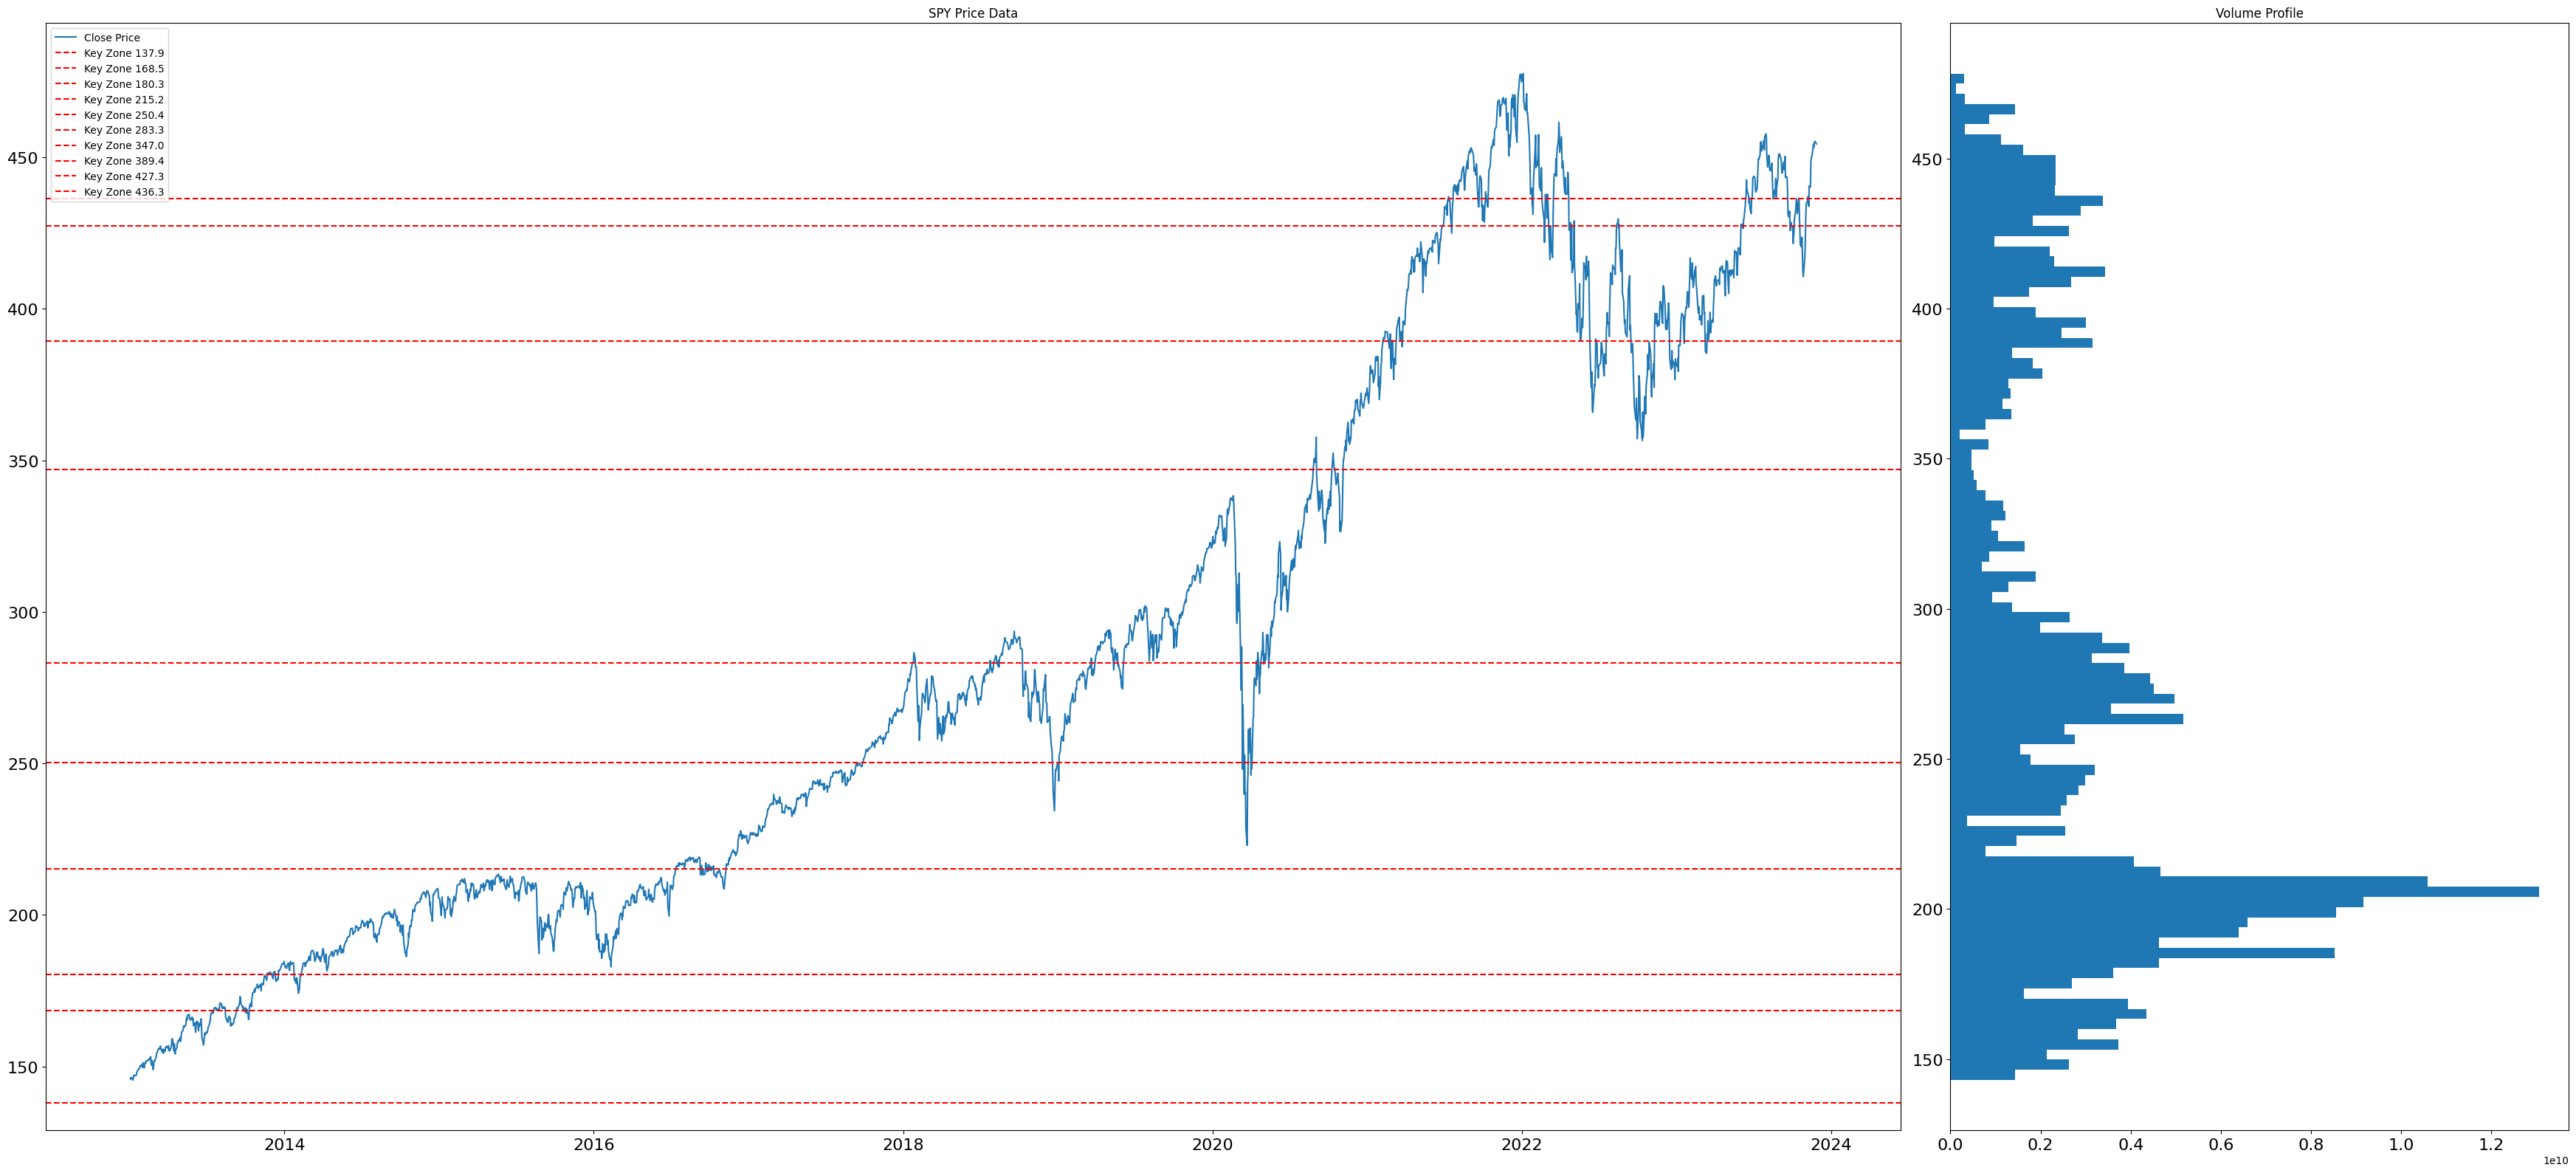

In [93]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 16), gridspec_kw={'width_ratios': [3, 1]})


ax1.plot(stock_data['Close'], label="Close Price")

for level in key_levels:
    ax1.axhline(y=level, color='r', linestyle='--', label=f'Key Zone {level:.1f}')

ax1.legend()
ax1.set_title(f'{symbol} Price Data')
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2.barh(price_bins[:-1], volume_profile, height=(price_bins[1] - price_bins[0]))
ax2.set_title('Volume Profile')
ax2.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()